In [ ]:
import tensorflow as tf
import gc
import os
import numpy as np
import tensorflow_datasets as tfds

In [ ]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]


In [ ]:
strategy = tf.distribute.TPUStrategy(resolver)

In [ ]:
!pip install hickle
import hickle as hkl
import os
import matplotlib.pyplot as plt
from keras import layers,Input,Sequential
from keras.layers import Dense,Flatten,Reshape,Conv2DTranspose,Conv2D,MaxPooling2D,Reshape,Resizing,Dropout,UpSampling2D
from tensorflow.keras import datasets, layers, models, losses, Model
from random import randint
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential,Model
import matplotlib.pyplot as plt
from google.colab  import drive
drive.mount("/gdrive")
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [ ]:
load_hkl = hkl.load("/gdrive/My Drive/Yedek/Autoencoder_Datasets_v2/Static/Left.hkl")
X_train_left=load_hkl['xtrain'] / 255.
X_test_left=load_hkl['xtest'] / 255.

del load_hkl
gc.collect()

load_hkl = hkl.load("/gdrive/My Drive/Yedek/Autoencoder_Datasets_v2/Static/Right.hkl")
X_train_right=load_hkl['xtrain'] / 255.
X_test_right=load_hkl['xtest'] / 255.

del load_hkl
gc.collect()

X_train_autoencoder=np.concatenate((X_train_left,X_train_right),axis=0)
X_test_autoencoder=np.concatenate((X_test_left,X_test_right),axis=0)
del X_train_right
del X_train_left
del X_test_left
del X_test_right

In [ ]:
X_train_autoencoder.shape

(376, 480, 640, 3)

In [ ]:
class CNN_Autoencoder(Model):
    def __init__(self):
        super(CNN_Autoencoder, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=X_train_autoencoder.shape[1:]),
            layers.Conv2D(8, 3, strides=1, padding='same', activation='relu'),
            layers.MaxPooling2D(2, strides=2),
            layers.Conv2D(16, 3, strides=1, padding='same', activation='relu'),
            layers.MaxPooling2D(2, strides=2),
            layers.Conv2D(32, 3, strides=1, padding='same', activation='relu')])

        self.decoder = tf.keras.Sequential([
            layers.Conv2D(32, 3, strides=1, padding='same', activation='relu'),
            layers.UpSampling2D(2),
            layers.Conv2D(16, 3, strides=1, padding='same', activation='relu'),
            layers.UpSampling2D(2),
            layers.Conv2D(3, 3, strides=1, padding='same', activation='relu')])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [ ]:
epochs=20

In [ ]:
with strategy.scope():
  cnn_autoencoder_right_left=CNN_Autoencoder()
  cnn_autoencoder_right_left.compile(optimizer='adam',  loss='mse',metrics=['accuracy'])
history=cnn_autoencoder_right_left.fit(X_train_autoencoder,X_train_autoencoder,epochs=epochs,
      batch_size=32, shuffle=True,validation_data=(X_test_autoencoder,X_test_autoencoder))

Epoch 1/20
12/12 [==============================] - 28s 2s/step - loss: 0.0745 - accuracy: 0.5845 - val_loss: 0.0240 - val_accuracy: 0.9371
Epoch 2/20
12/12 [==============================] - 5s 426ms/step - loss: 0.0156 - accuracy: 0.9647 - val_loss: 0.0098 - val_accuracy: 0.9667
Epoch 3/20
12/12 [==============================] - 5s 420ms/step - loss: 0.0057 - accuracy: 0.9783 - val_loss: 0.0023 - val_accuracy: 0.9751
Epoch 4/20
12/12 [==============================] - 5s 421ms/step - loss: 0.0019 - accuracy: 0.9817 - val_loss: 0.0016 - val_accuracy: 0.9810
Epoch 5/20
12/12 [==============================] - 5s 419ms/step - loss: 0.0014 - accuracy: 0.9837 - val_loss: 0.0012 - val_accuracy: 0.9846
Epoch 6/20
12/12 [==============================] - 5s 418ms/step - loss: 0.0010 - accuracy: 0.9871 - val_loss: 9.3204e-04 - val_accuracy: 0.9875
Epoch 7/20
12/12 [==============================] - 5s 433ms/step - loss: 8.5030e-04 - accuracy: 0.9871 - val_loss: 7.7043e-04 - val_accuracy: 0.9

In [ ]:
del X_train_autoencoder
del X_test_autoencoder

save_locally = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
cnn_autoencoder_right_left.save('/gdrive/My Drive/Models_Static_v2/Right', options=save_locally)

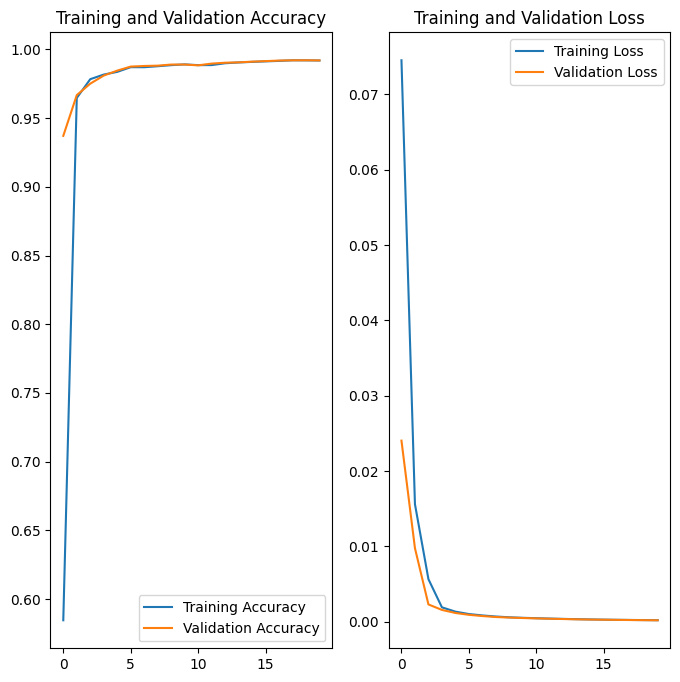

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
with strategy.scope():
    load_locally = tf.saved_model.LoadOptions(experimental_io_device='/job:localhost')
    reconstructed_right_left = tf.keras.models.load_model('/gdrive/My Drive/Models_Static_v2/Right', options=load_locally)

In [ ]:
load_hkl = hkl.load("/gdrive/My Drive/Yedek/Autoencoder_Datasets_filtered_v2/Static/Left.hkl")
X_train_left=load_hkl['xtrain'] / 255.
X_test_left=load_hkl['xtest'] / 255.
y_train=load_hkl['ytrain']
y_test=load_hkl['ytest']

del load_hkl
gc.collect()

load_hkl = hkl.load("/gdrive/My Drive/Yedek/Autoencoder_Datasets_filtered_v2/Static/Right.hkl")
X_train_right=load_hkl['xtrain'] / 255.
X_test_right=load_hkl['xtest'] / 255.

del load_hkl
gc.collect()

xm_train_left=reconstructed_right_left.encoder(X_train_left)
xm_test_left=reconstructed_right_left.encoder(X_test_left)

xm_train_right=reconstructed_right_left.encoder(X_train_right)
xm_test_right=reconstructed_right_left.encoder(X_test_right)

del X_train_right
del X_train_left
del X_test_left
del X_test_right

del reconstructed_right_left

In [ ]:
xm_train_left.shape

TensorShape([150, 120, 160, 32])

In [ ]:
xm_train_right.shape

TensorShape([150, 120, 160, 32])

In [ ]:
xm_train_left=tf.reshape(xm_train_left,[xm_train_left.shape[0],-1])
xm_test_left=tf.reshape(xm_test_left,[xm_test_left.shape[0],-1])

xm_train_right=tf.reshape(xm_train_right,[xm_train_right.shape[0],-1])
xm_test_right=tf.reshape(xm_test_right,[xm_test_right.shape[0],-1])

# **Concatenation of left and right vectors**

In [ ]:

  '''
  xm_train=np.empty((0,xm_train_left.shape[1]*2),dtype='float32')

  xm_test=np.empty((0,xm_test_left.shape[1]*2),dtype='float32')

  for i in range(xm_train_left.shape[0]):

      xm_train_1=np.empty((0,xm_train.shape[1]),dtype='float32')

      xm_train_1=np.concatenate((np.reshape(xm_train_right[i,:],(1,-1)),np.reshape(xm_train_left[i,:],(1,-1))),axis=1)

      xm_train=np.concatenate((xm_train,np.reshape(xm_train_1,(1,-1))),axis=0)

  for j in range(xm_test_left.shape[0]):

      xm_test_1=np.empty((0,xm_test.shape[1]),dtype='float32')

      xm_test_1=np.concatenate((np.reshape(xm_test_right[j,:],(1,-1)),np.reshape(xm_test_left[j,:],(1,-1))),axis=1)

      xm_test=np.concatenate((xm_test,np.reshape(xm_test_1,(1,-1))),axis=0)

  '''
xm_train=np.empty((0,xm_train_left.shape[1]),dtype='float32')

xm_test=np.empty((0,xm_test_left.shape[1]),dtype='float32')


for i in range(xm_train_left.shape[0]):

      xm_train_1=np.empty((0,xm_train_left.shape[1]),dtype='float32')

      xm_train_1=np.concatenate((xm_train_1,np.reshape(xm_train_left[i,:],(1,-1))),axis=0)
      xm_train_1=np.concatenate((xm_train_1,np.reshape(xm_train_right[i,:],(1,-1))),axis=0)

      xm_train=np.concatenate((xm_train,np.reshape(xm_train_1.max(axis=0),(1,-1))),axis=0)

for j in range(xm_test_left.shape[0]):

      xm_test_1=np.empty((0,xm_test_left.shape[1]),dtype='float32')

      xm_test_1=np.concatenate((xm_test_1,np.reshape(xm_test_left[j,:],(1,-1))),axis=0)
      xm_test_1=np.concatenate((xm_test_1,np.reshape(xm_test_right[j,:],(1,-1))),axis=0)

      xm_test=np.concatenate((xm_test,np.reshape(xm_test_1.max(axis=0),(1,-1))),axis=0)

del xm_train_1
del xm_test_1
del xm_train_left
del xm_train_right
print(xm_train.shape)
gc.collect()

(150, 614400)


23256

In [ ]:
xm_train.shape

(150, 614400)

In [ ]:
xm_test.shape

(63, 614400)

In [ ]:
xm_train=tf.reshape(xm_train,[xm_train.shape[0],-1])
xm_test=tf.reshape(xm_test,[xm_test.shape[0],-1])

## **Machine Learning**

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()

xm_train=scaler.fit_transform(xm_train)
xm_test=scaler.transform(xm_test)

In [ ]:
from sklearn.svm import SVC

svc=SVC(kernel="sigmoid")
svc.fit(xm_train, y_train)

SVC(kernel='sigmoid')

In [ ]:
y_pred=svc.predict(xm_test)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm=confusion_matrix(y_test, y_pred)
print(cm)
print(classification_report(y_test, y_pred))

[[35  3]
 [ 9 16]]
              precision    recall  f1-score   support

         0.0       0.80      0.92      0.85        38
         1.0       0.84      0.64      0.73        25

    accuracy                           0.81        63
   macro avg       0.82      0.78      0.79        63
weighted avg       0.81      0.81      0.80        63



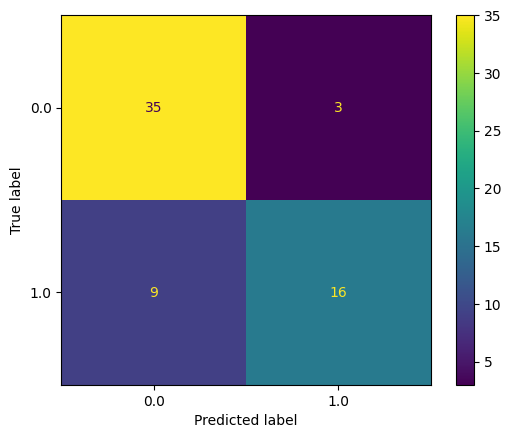

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svc.classes_)
disp.plot()